## Benchmark Black Litterman

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import yfinance as yf
import pypfopt 
import matplotlib.pyplot as plt

from pypfopt import black_litterman, plotting, objective_functions, risk_models
from pypfopt import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

### Data Collection

In [21]:
tickers = ["TSLA", "NVDA", "AMZN", "META", "RIVN", "INTC", "AMD"]

start_date = '2014-01-01'
end_date = '2024-01-01'

data = yf.download(tickers, start=start_date, end=end_date)

closing_prices = data["Adj Close"]
returns = np.log(closing_prices / closing_prices.shift(1).dropna())

def get_market_prices_and_caps(tickers, start_date, end_date):
    market_prices = yf.download("VOO", start=start_date, end=end_date)["Adj Close"]

    market_caps = {}
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        market_caps[ticker] = stock.info.get("marketCap", None)

    return market_prices, market_caps

closing_prices.tail(10)

[*********************100%***********************]  7 of 7 completed


Ticker,AMD,AMZN,INTC,META,NVDA,RIVN,TSLA
Date,,,,,,,
2023-12-15 00:00:00+00:00,139.149994,149.970001,45.549953,333.645508,48.876141,22.830000,253.500000
2023-12-18 00:00:00+00:00,138.899994,154.070007,45.086166,343.308594,50.062805,23.799999,252.080002
2023-12-19 00:00:00+00:00,140.149994,153.789993,46.043346,349.026733,49.589939,24.350000,257.220001
2023-12-20 00:00:00+00:00,135.470001,152.119995,45.155243,347.950836,48.097359,23.180000,247.139999
2023-12-21 00:00:00+00:00,139.910004,153.839996,46.457798,352.742523,48.976116,23.580000,254.500000
2023-12-22 00:00:00+00:00,139.600006,153.419998,47.365639,352.045227,48.816162,23.209999,252.539993
2023-12-26 00:00:00+00:00,143.410004,153.410004,49.832600,353.479736,49.265030,23.590000,256.609985
2023-12-27 00:00:00+00:00,146.070007,153.339996,50.089161,356.468323,49.402988,23.730000,261.440002
2023-12-28 00:00:00+00:00,148.759995,153.380005,49.724056,356.956451,49.507965,23.540001,253.179993


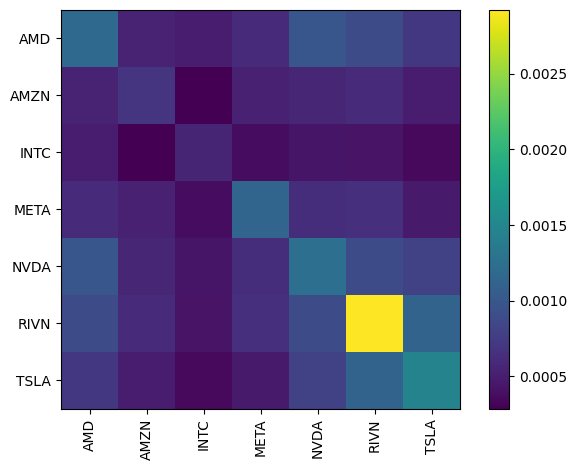

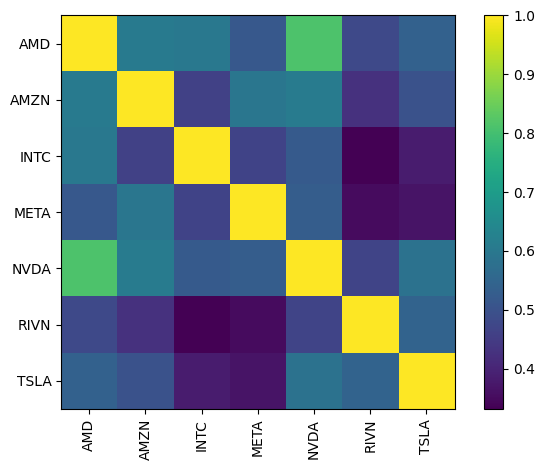

In [3]:
covariance_matrix = returns.cov()
covariance_plot = plotting.plot_covariance(covariance_matrix, plot_correlation=False)
correlation_plot = plotting.plot_covariance(covariance_matrix, plot_correlation=True)

In [4]:
covariance_matrix

Ticker,AMD,AMZN,INTC,META,NVDA,RIVN,TSLA
Ticker,,,,,,,
AMD,0.001181,0.000547,0.000489,0.000602,0.000990,0.000892,0.000709
AMZN,0.000547,0.000687,0.000286,0.000529,0.000567,0.000604,0.000501
INTC,0.000489,0.000286,0.000563,0.000376,0.000436,0.000425,0.000348
META,0.000602,0.000529,0.000376,0.001150,0.000633,0.000644,0.000476
NVDA,0.000990,0.000567,0.000436,0.000633,0.001252,0.000897,0.000791
RIVN,0.000892,0.000604,0.000425,0.000644,0.000897,0.002920,0.001124
TSLA,0.000709,0.000501,0.000348,0.000476,0.000791,0.001124,0.001462


### Get Prior and Delta

In [20]:
market_prices, market_caps = get_market_prices_and_caps(tickers, start_date, end_date)

delta = black_litterman.market_implied_risk_aversion(market_prices)
prior = black_litterman.market_implied_prior_returns(market_caps, delta, covariance_matrix)

prior

[*********************100%***********************]  1 of 1 completed


Ticker
AMD     0.022671
AMZN    0.022028
INTC    0.021314
META    0.022339
NVDA    0.023083
RIVN    0.022818
TSLA    0.022621
dtype: float64

### Define Investor Views

In [6]:
relative_views = np.array([0.20, 0.15, 0.10, -0.07]).reshape(-1, 1)

confidences = [0.2, 0.2, 0.2, 0.2]

picking_matrix = np.array([
    [1, 0, -1, 0, 0, 0, 0],  # TSLA - AMZN
    [0, 1, 0, -1, 0, 0, 0],  # NVDA - META
    [0, 0, 0, 1, 0, 0, -1],  # META - AMD
    [0, 0, 0, 0, 0, -1, 1]   # INTC - AMD
])

bl = BlackLittermanModel(
    cov_matrix=covariance_matrix, 
    pi=prior, 
    absolute_views=None, 
    Q=relative_views, 
    P=picking_matrix, 
    omega="idzorek", 
    view_confidences=confidences, 
    tau=0.025, 
    risk_aversion=delta
)

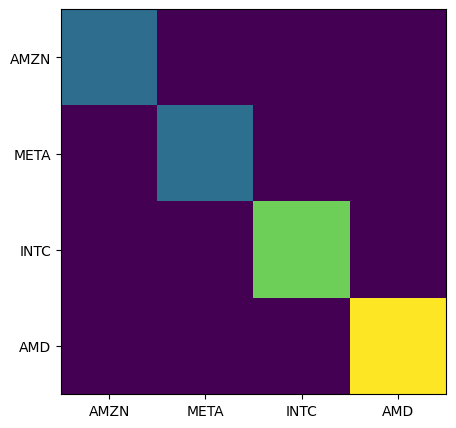

array([7.65875490e-05, 7.80082738e-05, 1.66030533e-04, 2.13560055e-04])

In [7]:
tickers_with_views = ["AMZN", "META", "INTC", "AMD"]

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(bl.omega)

ax.set_xticks(np.arange(len(tickers_with_views)))
ax.set_yticks(np.arange(len(tickers_with_views)))

ax.set_xticklabels(tickers_with_views)
ax.set_yticklabels(tickers_with_views)
plt.show()

np.diag(bl.omega)

### Calculate Posterior Returns

In [8]:
bl_returns = bl.bl_returns()
bl_returns

Ticker
AMD     0.055700
AMZN    0.043052
INTC    0.014697
META    0.020273
NVDA    0.047172
RIVN    0.047775
TSLA    0.024972
dtype: float64

In [9]:
relative_views_series = pd.Series(np.nan, index=tickers)
relative_views_series[:len(relative_views)] = relative_views.flatten()

returns_df = pd.DataFrame([prior, bl_returns, relative_views_series], index=["Prior", "Posterior", "Views"]).T
returns_df

,Prior,Posterior,Views
AMD,0.022671,0.055700,NaN
AMZN,0.022028,0.043052,0.10
INTC,0.021313,0.014697,NaN
META,0.022337,0.020273,-0.07
NVDA,0.023082,0.047172,0.15
RIVN,0.022819,0.047775,NaN
TSLA,0.022624,0.024972,0.20


<Axes: >

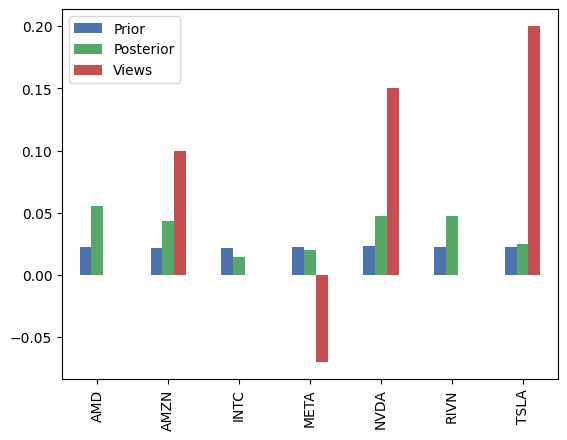

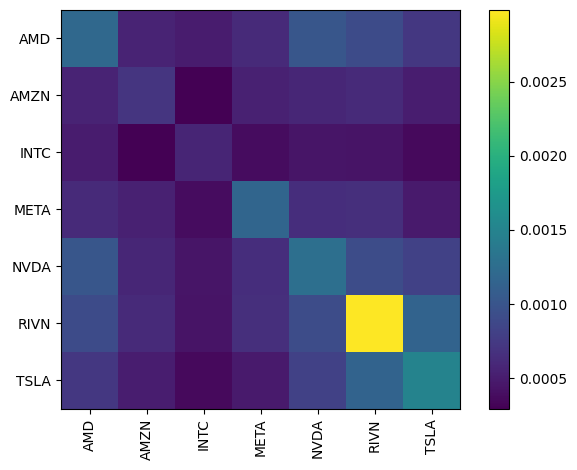

In [10]:
# visualisation of above
returns_df.plot.bar()

posterior_cov = bl.bl_cov()
plotting.plot_covariance(posterior_cov)

### Efficient Frontier Weights

In [11]:
ef = EfficientFrontier(bl_returns, posterior_cov)
# min_vol_weights = ef.min_volatility()
max_sharpe_weights = ef.max_sharpe()

cleaned_weights = ef.clean_weights()
cleaned_weights

OrderedDict([('AMD', 0.60871),
             ('AMZN', 0.39129),
             ('INTC', 0.0),
             ('META', 0.0),
             ('NVDA', 0.0),
             ('RIVN', 0.0),
             ('TSLA', 0.0)])

### Plot Asset Allocation

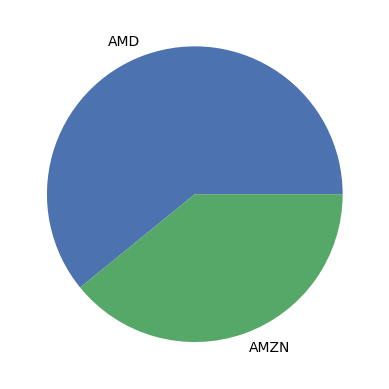

In [12]:
model_1_allocations = pd.Series(cleaned_weights).plot.pie()

### Portfolio Performance

In [13]:
ef.portfolio_performance(verbose=True)

Expected annual return: 5.1%
Annual volatility: 2.9%
Sharpe Ratio: 1.07


(0.05075065387008547, 0.028667044141622525, 1.0726831032236661)

### Get Discrete Allocation

In [19]:
latest_prices = get_latest_prices(closing_prices)
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=10000)
allocation, leftover = da.lp_portfolio(verbose=True)

#  quantities of shares that should be bought to have a 10,000£ portfolio
print(allocation)

Funds remaining: 5.75
AMD: allocated 0.605, desired 0.609
AMZN: allocated 0.395, desired 0.391
INTC: allocated 0.000, desired 0.000
META: allocated 0.000, desired 0.000
NVDA: allocated 0.000, desired 0.000
RIVN: allocated 0.000, desired 0.000
TSLA: allocated 0.000, desired 0.000
Allocation has RMSE: 0.002
{'AMD': 41, 'AMZN': 26}
